# Install Detectron2 and Roboflow

In [ ]:
!pip install -U 'git+https://github.com/facebookresearch/detectron2.git'
!pip install roboflow

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-9523bs8h
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-9523bs8h
  Resolved https://github.com/facebookresearch/detectron2.git to commit 65184fc057d4fab080a98564f6b60fae0b94edc4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.8 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6438614 sha256=a2d30a7030894c5ece83a0d57de54dcdb1e0346cd3ef3bcadc5ae044db00400e
  Stored in directory: /tmp/pip-ephem-wheel-cache-_bhgr3p8/wheels/17/d9/40/60db98e485aa9455

# **Download dataset directly from Roboflow (COCO Segmentation format)**

In [32]:
from roboflow import Roboflow
rf = Roboflow(api_key="zXKBghaxxiFAlpPEr2Vi")
project = rf.workspace("gouda-ibrahim-0bphy").project("bt-3ma9l")
version = project.version(1)
dataset = version.download("coco-segmentation")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to BT-1 in coco-segmentation:: 100%|██████████| 2890/2890 [00:00<00:00, 3391.17it/s]


In [34]:
import json

json_path = "BT-1/test/_annotations.coco.json"
with open(json_path) as f:
    data = json.load(f)

print("Categories:")
for cat in data["categories"]:
    print(cat)


Categories:
{'id': 0, 'name': 'null-tumor', 'supercategory': 'none'}
{'id': 1, 'name': 'brain tumor - v1 2024-04-23 11-31am', 'supercategory': 'null-tumor'}


In [46]:
import json

paths = [
    "BT-1/train/_annotations.coco.json",
    "BT-1/valid/_annotations.coco.json",
    "BT-1/test/_annotations.coco.json"
]

for path in paths:
    with open(path) as f:
        data = json.load(f)

    data["categories"] = [{"id": 1, "name": "Tumor"}]

    for ann in data["annotations"]:
        ann["category_id"] = 1

    with open(path, "w") as f:
        json.dump(data, f)

    print(f"The file has been fixed: {path}")


The file has been fixed: BT-1/train/_annotations.coco.json
The file has been fixed: BT-1/valid/_annotations.coco.json
The file has been fixed: BT-1/test/_annotations.coco.json


# **Register dataset in Detectron2 (COCO format with masks)**

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog


dataset_names = ["brain_train", "brain_val", "brain_test"]

for name in dataset_names:
    if name in DatasetCatalog.list():
        DatasetCatalog.remove(name)
        print(f"🗑️ DatasetCatalog: delete {name}")
    if name in MetadataCatalog.list():
        MetadataCatalog.remove(name)
        print(f"🗑️ MetadataCatalog: delete {name}")

In [48]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances(
    "brain_train", {},
    "BT-1/train/_annotations.coco.json",
    "BT-1/train"
)

register_coco_instances(
    "brain_val", {},
    "BT-1/valid/_annotations.coco.json",
    "BT-1/valid"
)

register_coco_instances(
    "brain_test", {},
    "BT-1/valid/_annotations.coco.json",
    "BT-1/valid"
)

# **Visualize samples with masks**

[06/13 16:47:23 d2.data.datasets.coco]: Loaded 2580 images in COCO format from BT-1/train/_annotations.coco.json


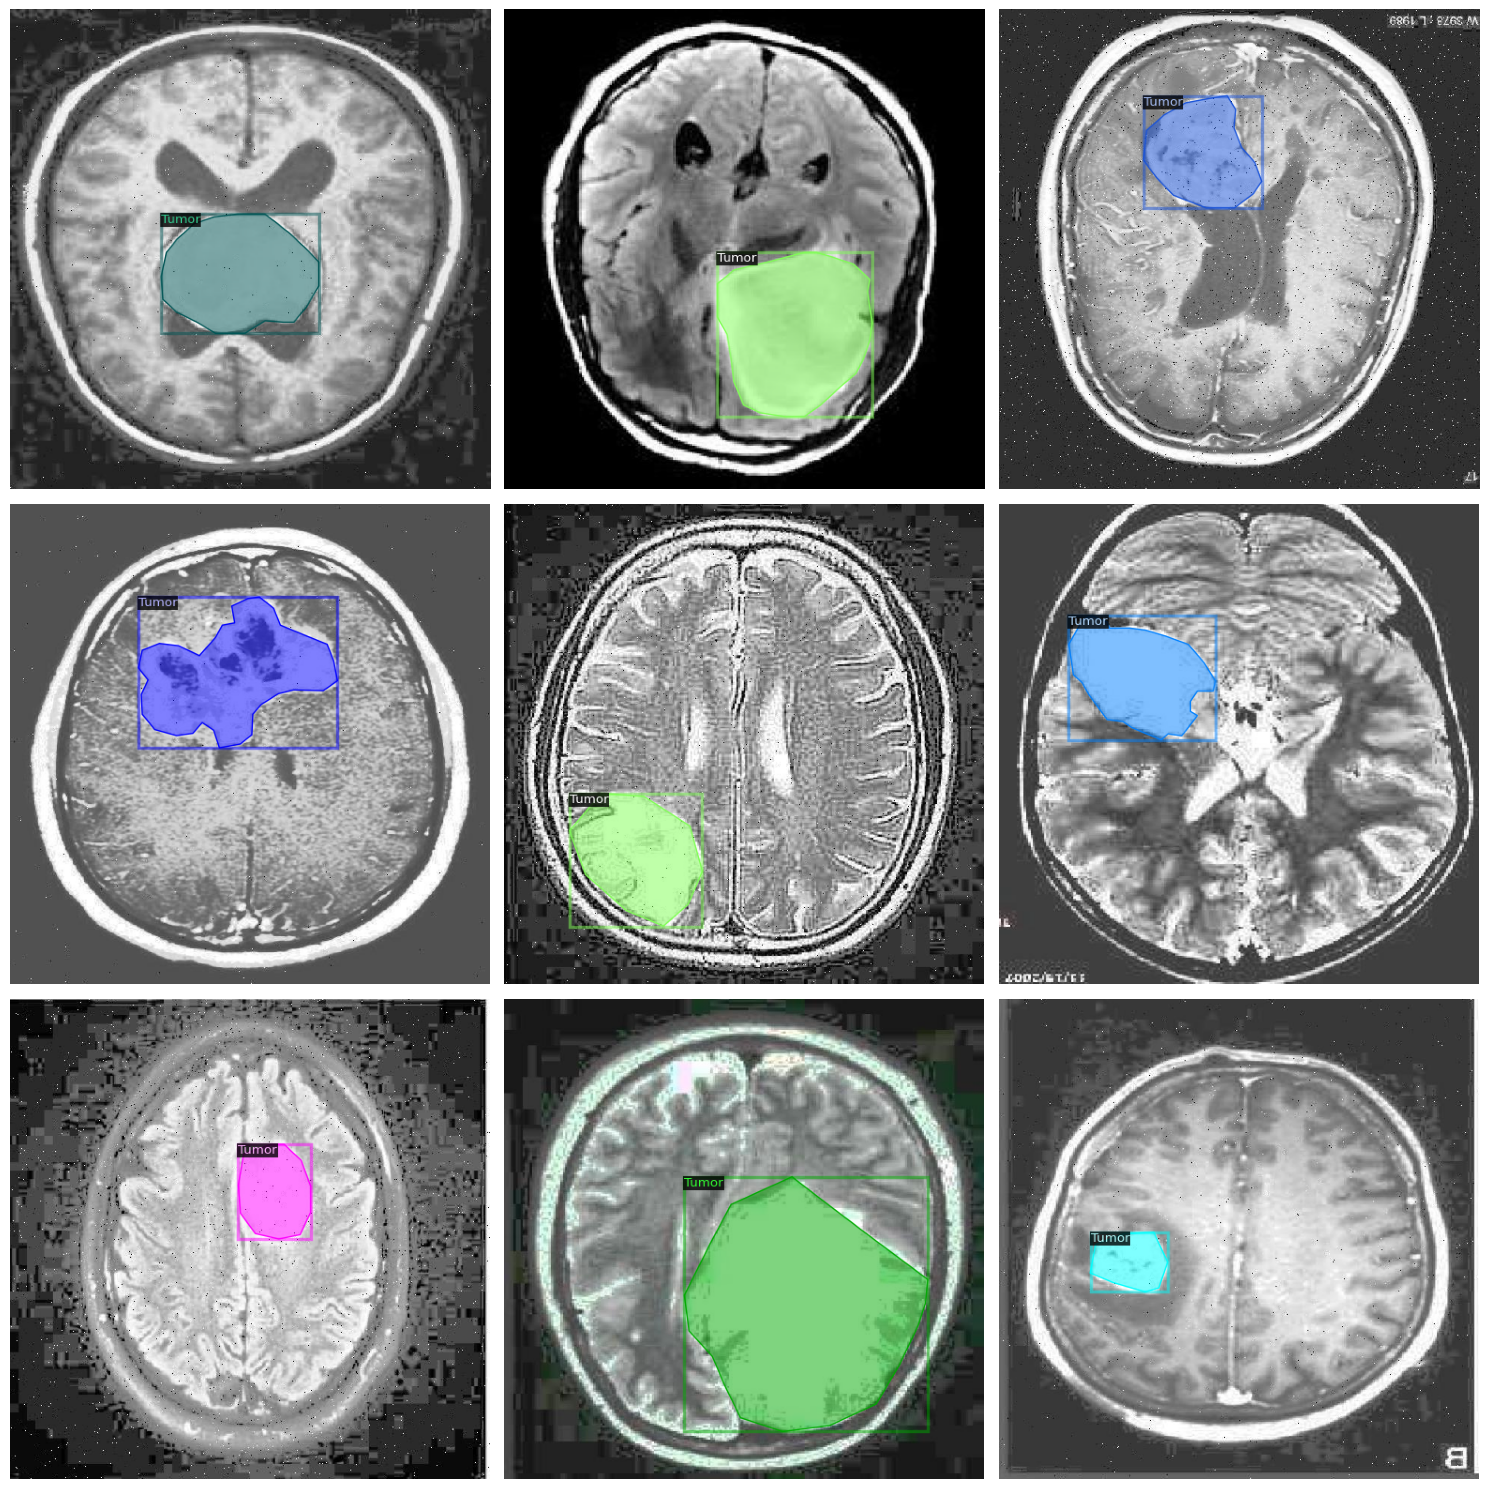

In [49]:
import random, cv2
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib.pyplot as plt

metadata = MetadataCatalog.get("brain_train")
dataset_dicts = DatasetCatalog.get("brain_train")

# Create a figure with a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten() # Flatten the 2D array of axes for easy iteration

for i, d in enumerate(random.sample(dataset_dicts, 9)):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8)
    vis = visualizer.draw_dataset_dict(d)

    # Display the image in the current subplot
    axs[i].imshow(vis.get_image()[:, :, ::-1])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# **Configure and train Mask R-CNN**

In [50]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("brain_train",)
cfg.DATASETS.TEST = ("brain_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.INPUT.MASK_FORMAT = "bitmask"
cfg.OUTPUT_DIR = "./output_mask_rcnn"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()



[06/13 16:47:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[06/13 16:47:54 d2.engine.train_loop]: Starting training from iteration 0
[06/13 16:48:01 d2.utils.events]:  eta: 0:54:19  iter: 19  total_loss: 1.526  loss_cls: 0.5359  loss_box_reg: 0.2841  loss_mask: 0.689  loss_rpn_cls: 0.02127  loss_rpn_loc: 0.005929    time: 0.3209  last_time: 0.3264  data_time: 0.0182  last_data_time: 0.0058   lr: 4.9953e-06  max_mem: 2445M
[06/13 16:48:08 d2.utils.events]:  eta: 0:54:26  iter: 39  total_loss: 1.516  loss_cls: 0.4798  loss_box_reg: 0.2897  loss_mask: 0.6824  loss_rpn_cls: 0.03717  loss_rpn_loc: 0.006237    time: 0.3250  last_time: 0.3787  data_time: 0.0114  last_data_time: 0.0127   lr: 9.9902e-06  max_mem: 2446M
[06/13 16:48:14 d2.utils.events]:  eta: 0:54:29  iter: 59  total_loss: 1.492  loss_cls: 0.4043  loss_box_reg: 0.3983  loss_mask: 0.6609  loss_rpn_cls: 0.03534  loss_rpn_loc: 0.007257    time: 0.3274  last_time: 0.3690  data_time: 0.0114  last_data_time: 0.0053   lr: 1.4985e-05  max_mem: 2447M
[06/13 16:48:21 d2.utils.events]:  eta: 0:54:

# **Inference & Evaluation using the trained model**

[06/13 17:51:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output_mask_rcnn/model_final.pth ...
[06/13 17:51:05 d2.data.datasets.coco]: Loaded 181 images in COCO format from BT-1/valid/_annotations.coco.json


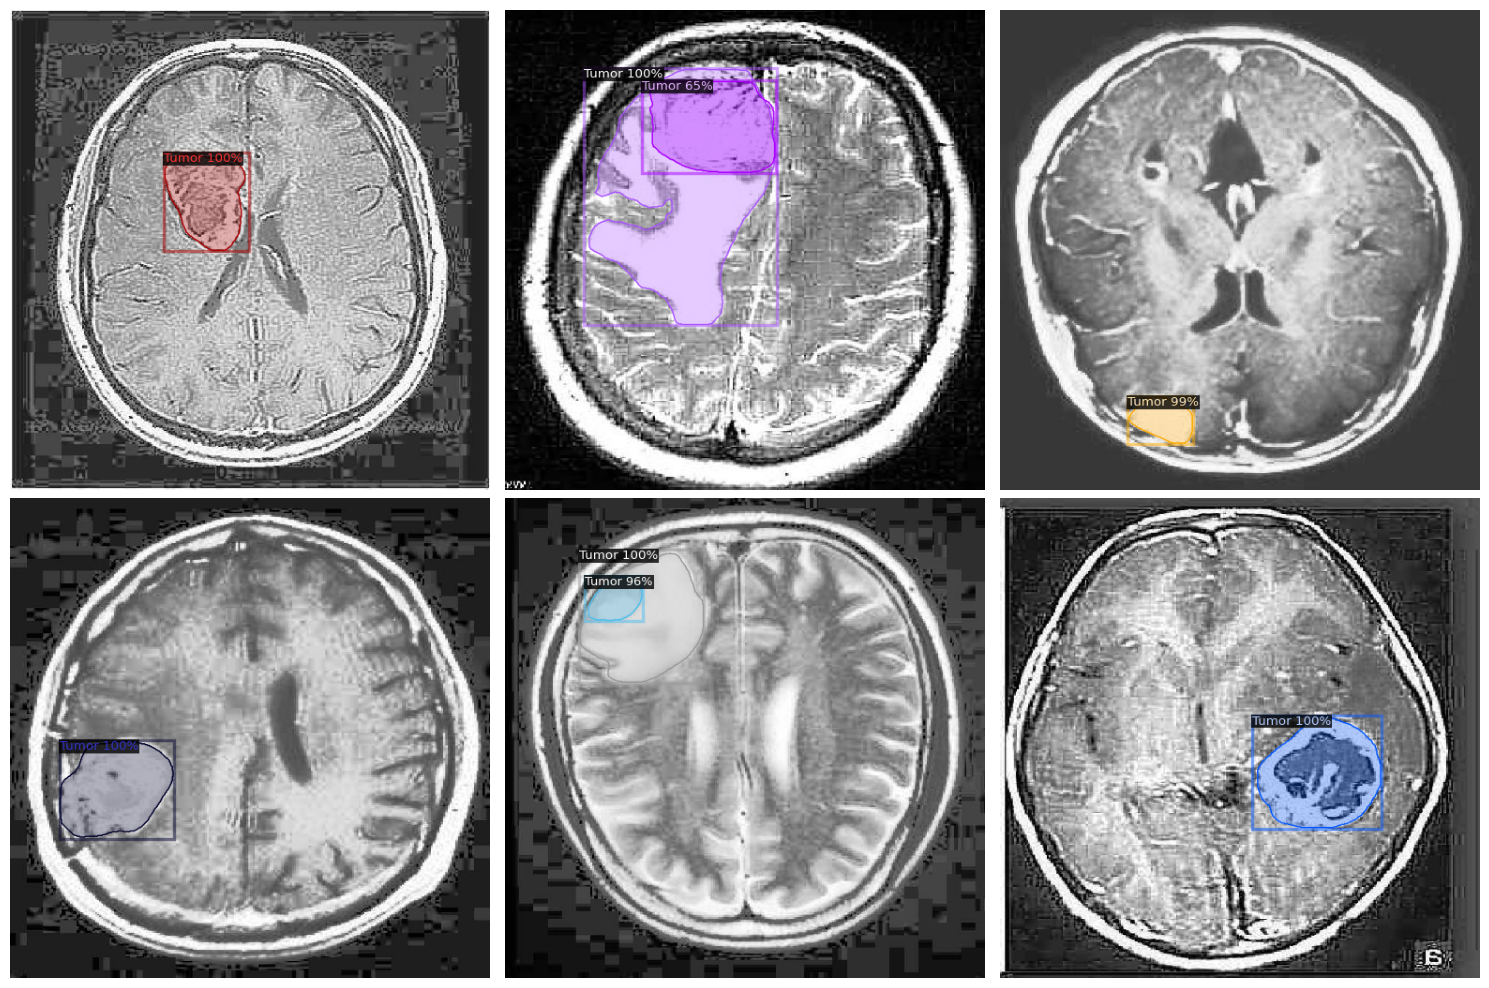

In [52]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt
import random

# Load trained weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # confidence threshold
predictor = DefaultPredictor(cfg)

# Run inference on random validation images
dataset_dicts = DatasetCatalog.get("brain_val")

# Create a figure with a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten() # Flatten the 2D array of axes for easy iteration

for i, d in enumerate(random.sample(dataset_dicts, 6)):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=MetadataCatalog.get("brain_val"),
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Display the image in the current subplot
    axs[i].imshow(v.get_image())
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# **Evaluation metrics (Precision, Recall, mAP)**

In [53]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("brain_val", cfg, False, output_dir="./output_mask_rcnn/")
val_loader = build_detection_test_loader(cfg, "brain_val")

print("Evaluating model on validation set...")
metrics = inference_on_dataset(predictor.model, val_loader, evaluator)
print(metrics)


WARNING [06/13 17:51:24 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[06/13 17:51:24 d2.data.datasets.coco]: Loaded 181 images in COCO format from BT-1/valid/_annotations.coco.json
[06/13 17:51:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/13 17:51:24 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/13 17:51:24 d2.data.common]: Serializing 181 elements to byte tensors and concatenating them all ...
[06/13 17:51:24 d2.data.common]: Serialized dataset takes 0.11 MiB
Evaluating model on validation set...
[06/13 17:51:24 d2.evaluation.evaluator]: Start inference on 181 batches
[06/13 17:51:25 d2.evaluation.evaluator]: Inference done 11/181. Dataloading: 0.0012 s/iter. Inference: 0.0787 s/iter. Eval: 0.0016 s/iter

# Testing random data

[06/13 18:06:10 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output_mask_rcnn/model_final.pth ...
[06/13 18:06:11 d2.data.datasets.coco]: Loaded 181 images in COCO format from BT-1/valid/_annotations.coco.json


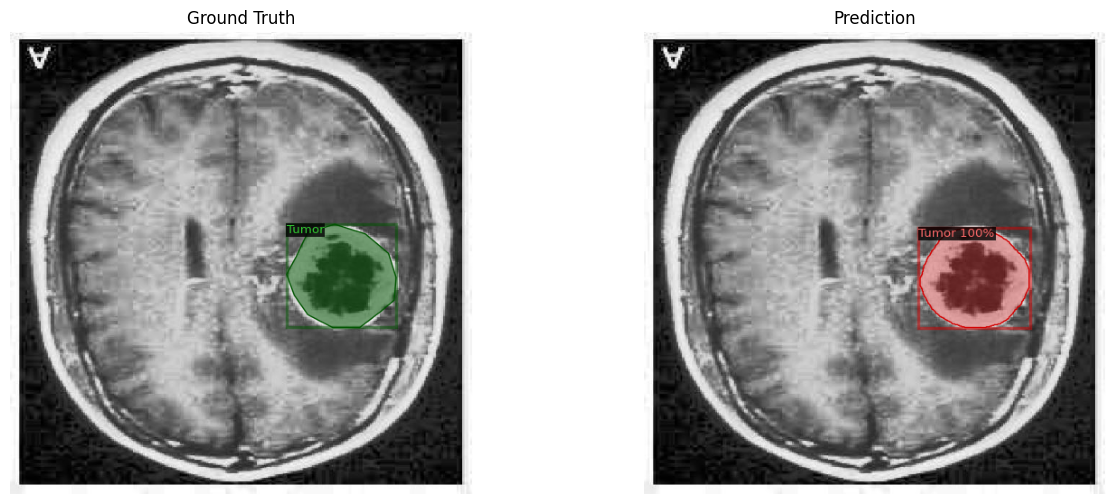

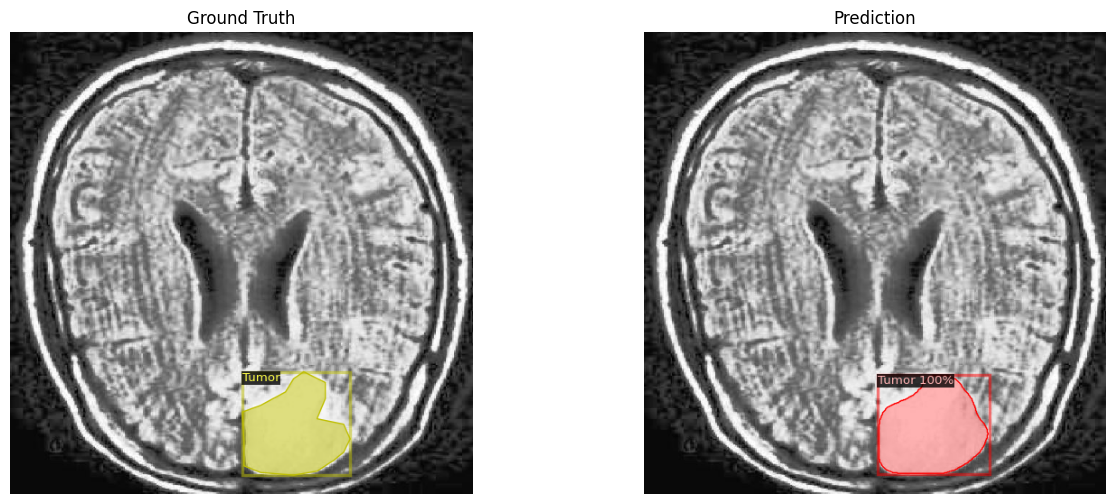

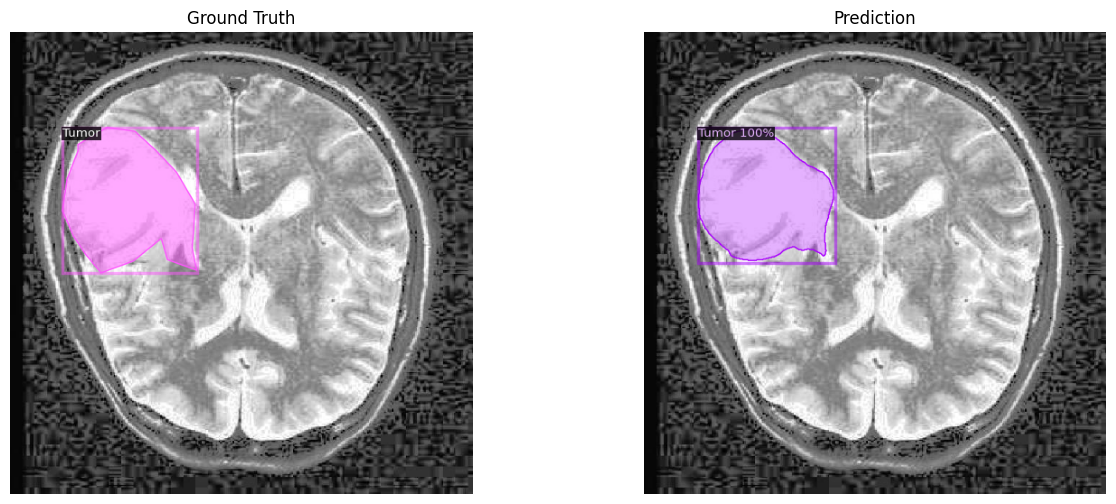

In [70]:
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg.DATASETS.TEST = ("brain_test",)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)


dataset_dicts = DatasetCatalog.get("brain_test")
metadata = MetadataCatalog.get("brain_test")


for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])

    # ground truth
    v_gt = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8)
    v_gt = v_gt.draw_dataset_dict(d)

    # prediction
    outputs = predictor(img)
    v_pred = Visualizer(img[:, :, ::-1],
                        metadata=metadata,
                        scale=0.8,
                        instance_mode=ColorMode.IMAGE_BW)
    v_pred = v_pred.draw_instance_predictions(outputs["instances"].to("cpu"))


    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].imshow(v_gt.get_image())
    axs[0].set_title("Ground Truth")
    axs[0].axis("off")

    axs[1].imshow(v_pred.get_image())
    axs[1].set_title("Prediction")
    axs[1].axis("off")

    plt.show()


Saving Tr-me_0019.jpg to Tr-me_0019.jpg
Processing uploaded file: Tr-me_0019.jpg


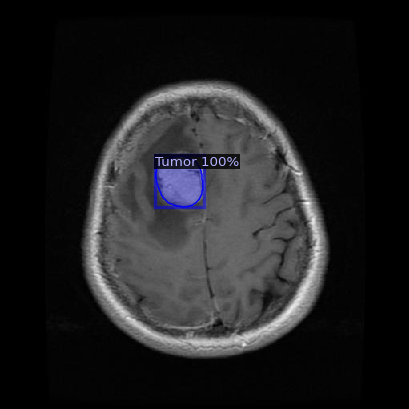

In [72]:
# prompt: upload data from my device and test by our model

from google.colab import files
uploaded = files.upload()

import os
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.config import get_cfg
import cv2
from google.colab.patches import cv2_imshow
from detectron2.data import MetadataCatalog


# Iterate through the uploaded files
for filename in uploaded.keys():
  print(f'Processing uploaded file: {filename}')
  # Read the uploaded image
  img = cv2.imread(filename)

  if img is None:
    print(f"Error: Could not read image file {filename}")
    continue

  # Perform inference
  outputs = predictor(img)

  metadata = MetadataCatalog.get("brain_test")


  v = Visualizer(img[:, :, ::-1],
                 metadata=metadata, # Use the test metadata
                 scale=0.8,
                 instance_mode=ColorMode.IMAGE_BW   # or ColorMode.SEGMENTATION
                )
  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

  # Display the result
  cv2_imshow(v.get_image())

In [74]:
# prompt: upload tha dataset BT-1 & output_mask_rcnn & notebokk to my drive

!zip -r BT-1.zip BT-1
!zip -r output_mask_rcnn.zip output_mask_rcnn

from google.colab import drive
drive.mount('/content/drive')

!cp BT-1.zip /content/drive/My\ Drive/
!cp output_mask_rcnn.zip /content/drive/My\ Drive/
!cp /content/MaskRCNN_BrainTumor_Detectron2_Roboflow_v2.ipynb /content/drive/My\ Drive/

updating: BT-1/ (stored 0%)
updating: BT-1/train/ (stored 0%)
updating: BT-1/train/y199_jpg.rf.873756340731d04614265bceef726af3.jpg (deflated 2%)
updating: BT-1/train/y465_jpg.rf.9335099b63f5ff65ca69ba8027119100.jpg (deflated 2%)
updating: BT-1/train/y186_jpg.rf.b363d6c9413044f5182d24b73f92d659.jpg (deflated 4%)
updating: BT-1/train/y478_jpg.rf.da9a9325f503e4c9a661fd31e043f1d0.jpg (deflated 1%)
updating: BT-1/train/y305_jpg.rf.2c942ce97bf21bd7f404589fa7a4fe56.jpg (deflated 4%)
updating: BT-1/train/y307_jpg.rf.fa83638e825fe896bb0ca5992c9ba61a.jpg (deflated 3%)
updating: BT-1/train/y307_jpg.rf.d1c4b3e59c9fbdaa38134a808891ac2b.jpg (deflated 3%)
updating: BT-1/train/y435_jpg.rf.c6110ba5d58beda2cdac0372a033b711.jpg (deflated 0%)
updating: BT-1/train/y160_jpg.rf.4074e25dafd6edfc28027ff8bda9079e.jpg (deflated 1%)
updating: BT-1/train/y336_jpg.rf.7a46bd87eba4b6b1433000ccfe1872ed.jpg (deflated 5%)
updating: BT-1/train/Te-me_0043_jpg.rf.2acac902b7ede1938e5a29e301fd47b0.jpg (deflated 3%)
updating